# Shelter Animals Outcomes (Kaggle)

In [53]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from datetime import date, datetime
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import cross_validation

from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
from scipy.spatial.distance import cdist



**Utility functions**

In [3]:
def age_years(x):
    if(pd.isnull(x)):
        return 0
    
    age = int(x.split(' ')[0])
        
    if 'month' in x:
        age /= 12.0

    elif 'week' in x:
        age /= 52.0

    elif 'day' in x:
        age /= 365.0

    elif 'year' in x:
        age = age
    else:
        age = 0

    return age

def get_breed(line):
    #special case this miscoded value : should be Black and Tan hound Mix (Black and Tan hound is a breed)
    if line == 'Black/Tan Hound Mix':
        return 'purebreed_mix'
        
    if '/' in line:
        breed2 = line.split('/')[1]
        if 'unknown' in breed2:
            return 'purebreed_unknown'
        else:
            return 'purebreed_purebreed'
    elif 'unknown' in line:
        return "unknown"
    elif 'mix' in line:
      return "purebreed_mix"
    else:
        return "purebreed"


def get_color(x):
    if pd.isnull(x):
        return x
    colors = x.strip().split('/')
    if len(colors) == 1:
        return "single_color"
    elif len(colors) == 2:
        return "double_color"
    else:
        return "twoplus_color" 

In [4]:

# read in train and test data
train = pd.read_csv('C:\\Subha\\WS207-ML\\Kaggle\\git\\train.csv', parse_dates=['DateTime'])
test = pd.read_csv('C:\\Subha\\WS207-ML\\Kaggle\\git\\test.csv', parse_dates=['DateTime'])


train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Combine train and test data into one for feature engineering; later we will split it again**


In [6]:
# get number of training elements
train_num = train.shape[0]
train.rename(columns={'AnimalID': 'ID'}, inplace=True)
all_data = pd.concat((train, test), axis=0, ignore_index=True)

print "train data:", train.shape     #26,729 rows
print "test data:", test.shape      #11,456
print "all data:", all_data.shape  #38,185


train data: (26729, 10)
test data: (11456, 8)
all data: (38185, 10)


In [8]:
all_data['OutcomeType']= all_data['OutcomeType'].str.lower()
all_data['OutcomeType']= all_data['OutcomeType'].str.strip()
all_data['OutcomeType']= all_data['OutcomeType'].astype('category')
#11456 null values in the outcome type; all correspond to test data
print "Null values in OutcomeType:", sum(pd.isnull(all_data['OutcomeType'])) 


Null values in OutcomeType: 11456


**Name, AnimalType,SexUponoutcome*** are recoded to categories and dummy variables created where necessary

In [9]:
#does it have a name?
all_data['Name'] = all_data['Name'].str.strip()
all_data['Hasname'] = all_data['Name'].map(lambda x: 1 if not pd.isnull(x) and x else 0)
print all_data['Hasname'].value_counts()

1    27269
0    10916
Name: Hasname, dtype: int64


In [10]:
all_data['AnimalType'] = all_data['AnimalType'].str.lower()
all_data['AnimalType'] = all_data['AnimalType'].str.strip()
all_data['Iscat'] = all_data['AnimalType'].map(lambda x: 1 if x=='cat' else 0)
#no missing values
print "Null Values in AnimalType:", sum(pd.isnull(all_data['Iscat']))  


Null Values in AnimalType: 0


In [13]:
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.lower()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].str.strip()
all_data['SexuponOutcome'] = all_data['SexuponOutcome'].astype('category')
print all_data['SexuponOutcome'].value_counts()
#missing value, convert to Unknown category
all_data['SexuponOutcome'][pd.isnull(all_data['SexuponOutcome'])] = "unknown"
print "Null values in SexuponOutcome:", sum(pd.isnull(all_data['SexuponOutcome']))

all_data = pd.concat((all_data,pd.get_dummies(all_data['SexuponOutcome'])), axis=1)


neutered male    14014
spayed female    12633
intact female     5004
intact male       4985
unknown           1549
dtype: int64
Null values in SexuponOutcome: 0


**For age**, create 2 variables: 
- one a continuous float value for age in years 
- the other a categorical value for various life stages.

In [15]:
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.lower()
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].str.strip()
all_data['Ageyears'] = map(age_years, all_data['AgeuponOutcome'])
all_data['Ageyears'].describe()

#24 values are unknkown
print "Null values in AgeuponOutcome:", sum(pd.isnull(all_data['AgeuponOutcome'])) 
#all nulls were coded to 0
print "Null values in Ageyears:", sum(pd.isnull(all_data['Ageyears'])) 

Null values in AgeuponOutcome: 24
Null values in Ageyears: 0


In [14]:

#create cat and dog age categories 
#source - http://www.akc.org/learn/family-dog/how-to-calculate-dog-years-to-human-years/
#http://icatcare.org/advice/how-guides/how-tell-your-cat%E2%80%99s-age-human-years
age_labels_dogs=['baby', 'adolescent', 'adult', 'senior']
age_ranges_dogs=[0.0, 1.0, 2.0, 7.0, 30.0]
age_ranges_cats=[0.0, 0.5, 2.0, 6.0, 10.0,15.0, 30.0]
age_labels_cats=['baby', 'adolescent', 'adult','mature', 'senior', 'geriatric']


#compute the dog age and cat age categories separately, then merge them
all_data['dog_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='dog'], age_ranges_dogs,  labels=age_labels_dogs)
all_data['cat_ages'] = pd.cut(all_data['Ageyears'][all_data['AnimalType']=='cat'], age_ranges_cats,  labels=age_labels_cats)
#merge
all_data['Agecategory'] = [all_data['dog_ages'][x] 
                               if not pd.isnull(all_data['dog_ages'][x]) 
                               else all_data['cat_ages'][x] 
                                   for x in range(all_data['dog_ages'].size)]

all_data['Agecategory'] = all_data['Agecategory'].astype('category')
print all_data['Agecategory'].value_counts()

#drop the temp columns
all_data.drop(['dog_ages', 'cat_ages'], axis=1, inplace=True)

#the AgeuponOutcome had 24 missing values, whereas the Agecategory has 59. The extra nulls are due to age=0
print "Null values in Agecategory:", sum(pd.isnull(all_data['Agecategory']))
#all_data['AgeuponOutcome'][pd.isnull(all_data['Agecategory'])]

all_data = pd.concat((all_data, pd.get_dummies(all_data['Agecategory'])), axis=1)



Null values in Age: 0
baby          20346
adolescent     7742
adult          7030
senior         2342
mature          624
geriatric        42
dtype: int64
Null values in Agecategory: 59


**Datetime field** is split up into several numerical variables, and one categorical variable AM/PM.
- Hour of day [00,23]
- Day of the week (0=Sunday,1=Monday, ..)
- Day of the month [00,32]
- Month [00-12]
- Week of the year [00,53]
- Two digit year


In [17]:
all_data['Hour'] = all_data.DateTime.apply(lambda d: d.strftime('%H')).astype('int') # [00,23]
all_data['Ampm'] = all_data.DateTime.apply(lambda d: d.strftime('%p')) # Am/pm
all_data['Dayofweek'] = all_data.DateTime.apply(lambda d: d.strftime('%w')).astype('int') # [0(sunday),6]
all_data['Dayofmonth'] = all_data.DateTime.apply(lambda d: d.strftime('%d')).astype('int') # 01,02,..31
all_data['Month'] = all_data.DateTime.apply(lambda d: d.strftime('%m')).astype('int')   # Month as a number
all_data['Weekofyear'] = all_data.DateTime.apply(lambda d: d.strftime('%U')).astype('int')  # [00,53]
all_data['Year'] = all_data.DateTime.apply(lambda d: d.strftime('%y')).astype('int') # two digit year

all_data.Hour.value_counts()
all_data.Ampm.value_counts()
all_data.Dayofweek.value_counts()
all_data.Dayofmonth.value_counts()
all_data.Month.value_counts()
all_data.Weekofyear.value_counts()
all_data.Year.value_counts()

dummies = pd.get_dummies(all_data['Ampm'])
all_data = pd.concat((all_data, dummies), axis=1)


**Breed and Color** are coded in 2 separate ways:
1. Create a categorical meta variable for breed (purebreed, mixed, etc) and color (single, double, etc)
2. Use CountVectorizer to encode Breed and Color. 

Whereas Breed has around 138 unique categories and color has 366, once they are vectorized we get around 200 breed-related featues and 32 color-related features.

In [16]:
all_data['Breed'] = all_data['Breed'].str.lower()
all_data['Breed'] = all_data['Breed'].str.strip()

#breed type
all_data['Breedtype'] = all_data['Breed'].map(get_breed)
all_data['Breedtype'].value_counts()

all_data = pd.concat((all_data, pd.get_dummies(all_data['Breedtype'])), axis=1)

all_data['Color'] = all_data['Color'].str.lower()
all_data['Color'] = all_data['Color'].str.strip()

all_data['Colortype'] = all_data['Color'].map(get_color)
all_data['Colortype'].value_counts()

#no missing values
print "Null values in Color:", sum(pd.isnull(all_data['Color']))
print "Null values in ColorType:", sum(pd.isnull(all_data['Colortype']))

all_data = pd.concat((all_data, pd.get_dummies(all_data['Colortype'], prefix='col')), axis=1)


Null values in Color: 0
Null values in ColorType: 0


In [18]:
vec = CountVectorizer(min_df=10)
breeds = vec.fit_transform(all_data['Breed'])
breeds = breeds.toarray()
breeds.shape
#create new features from breed names
for ii in range(breeds.shape[1]):
    colname = 'breed_%d' %ii
    all_data[colname] = pd.Series(breeds[:,ii])

#--------------------------------------------------------------------------------------------------


vec = CountVectorizer(min_df=10)
colors = vec.fit_transform(all_data['Color'])
colors = colors.toarray()
colors.shape
#create new features from breed names
for ii in range(colors.shape[1]):
    colname = 'color_%d' %ii
    all_data[colname] = pd.Series(colors[:,ii])



######  That's it for feature engineering. Now split the train and test data back.

In [19]:
train_data = all_data.iloc[:train_num]
test_data = all_data.iloc[train_num:]
test_ids = all_data['ID'][train_num:].values
train_labels = train_data.OutcomeType

print "train data:", train_data.shape, "Test data:", test_data.shape


train data: (26729, 268) Test data: (11456, 268)


In [24]:
#drop the columns we don't need
cols_recoded = [
 'AgeuponOutcome',
 'AnimalType',
 'Breed',
 'Color',
 'DateTime',
 'Name',
 'SexuponOutcome',
 'Agecategory',
 'Breedtype',
 'Colortype',
 'unknown',
 'Ampm']


train_data = train_data.drop(cols_recoded, axis=1)
test_data = test_data.drop(cols_recoded, axis=1)

other_cols = [
  'ID',
 'OutcomeSubtype',
 'OutcomeType']
train_data = train_data.drop(other_cols, axis=1)
test_data = test_data.drop(other_cols, axis=1)


In [26]:
#the final feature set
print [item for item in train_data.columns]
print "Number of features:", train_data.shape[1]

['Hasname', 'Iscat', 'intact female', 'intact male', 'neutered male', 'spayed female', 'intact female', 'intact male', 'neutered male', 'spayed female', 'intact female', 'intact male', 'neutered male', 'spayed female', 'Ageyears', 'adolescent', 'adult', 'baby', 'geriatric', 'mature', 'senior', 'purebreed', 'purebreed_mix', 'purebreed_purebreed', 'purebreed_unknown', 'col_double_color', 'col_single_color', 'Hour', 'Dayofweek', 'Dayofmonth', 'Month', 'Weekofyear', 'Year', 'AM', 'PM', 'breed_0', 'breed_1', 'breed_2', 'breed_3', 'breed_4', 'breed_5', 'breed_6', 'breed_7', 'breed_8', 'breed_9', 'breed_10', 'breed_11', 'breed_12', 'breed_13', 'breed_14', 'breed_15', 'breed_16', 'breed_17', 'breed_18', 'breed_19', 'breed_20', 'breed_21', 'breed_22', 'breed_23', 'breed_24', 'breed_25', 'breed_26', 'breed_27', 'breed_28', 'breed_29', 'breed_30', 'breed_31', 'breed_32', 'breed_33', 'breed_34', 'breed_35', 'breed_36', 'breed_37', 'breed_38', 'breed_39', 'breed_40', 'breed_41', 'breed_42', 'breed_

### Now we are ready to fit models!

In [40]:

def draw_cm(y_true, y_pred,label_names):
    
    def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    cm = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)

In [41]:
# use K-fold cross validation with k=6

def fit_model(clf):
    labels =  train_labels.cat.categories

    kf = KFold(train_data.shape[0], n_folds=6)
    # prediction probabilities number of samples, by number of classes
    y_pred_proba = np.zeros((len(train_labels),len(set(train_labels))))

    for train_index, test_index in kf:
        X_train, X_test = train_data.iloc[train_index], train_data.iloc[test_index]
        y_train, y_test = train_labels.iloc[train_index], train_labels.iloc[test_index]
        print X_train.shape, X_test.shape
        clf.fit(X_train, y_train)
        y_pred_proba[test_index] = clf.predict_proba(X_test)

    print "Log Loss:", metrics.log_loss(train_labels, y_pred_proba)    
    y_pred = [labels[row.argmax()] for row in y_pred_proba]
    print metrics.classification_report(train_labels, y_pred)
    draw_cm(train_labels, y_pred,labels)

** Logistic Regression **

(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22275, 250) (4454, 250)
Log Loss: 0.863701820372
             precision    recall  f1-score   support

   adoption       0.66      0.83      0.74     10769
       died       0.00      0.00      0.00       197
 euthanasia       0.59      0.06      0.11      1555
return_to_owner       0.48      0.44      0.46      4786
   transfer       0.73      0.67      0.70      9422

avg / total       0.64      0.65      0.63     26729

Confusion matrix, without normalization
[[8933    0    4 1193  639]
 [  19    0    4   11  163]
 [ 205    0   91  347  912]
 [2017    0   23 2096  650]
 [2331    0   31  706 6354]]


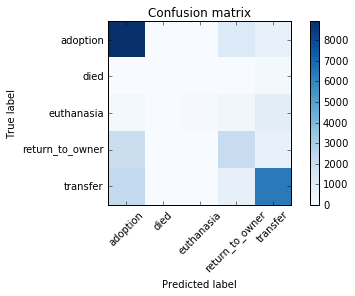

In [42]:
#plain and simple
clf = LogisticRegression()
fit_model(clf)

In [30]:
#with L1 regularization
clf = LogisticRegression(penalty="l1")
fit_model(clf)

(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22275, 250) (4454, 250)
Log Loss: 0.862414973565
             precision    recall  f1-score   support

   adoption       0.66      0.83      0.74     10769
       died       0.00      0.00      0.00       197
 euthanasia       0.62      0.06      0.10      1555
return_to_owner       0.48      0.44      0.46      4786
   transfer       0.73      0.68      0.70      9422

avg / total       0.65      0.65      0.63     26729



** Random Forest**

In [31]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
fit_model(clf)

(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22275, 250) (4454, 250)
Log Loss: 0.818807799522
             precision    recall  f1-score   support

   adoption       0.69      0.84      0.76     10769
       died       0.75      0.03      0.06       197
 euthanasia       0.58      0.13      0.21      1555
return_to_owner       0.50      0.44      0.47      4786
   transfer       0.75      0.72      0.73      9422

avg / total       0.67      0.68      0.66     26729



** AdaBoost classifier **

(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22275, 250) (4454, 250)
Log Loss: 1.5533640347
             precision    recall  f1-score   support

   adoption       0.68      0.49      0.57     10769
       died       0.03      0.36      0.06       197
 euthanasia       0.21      0.37      0.27      1555
return_to_owner       0.30      0.71      0.43      4786
   transfer       0.65      0.20      0.31      9422

avg / total       0.57      0.42      0.43     26729

Confusion matrix, without normalization
[[5303   32  220 4755  459]
 [  14   70   45   17   51]
 [ 104  134  577  474  266]
 [ 915    4  223 3407  237]
 [1426 1780 1714 2581 1921]]


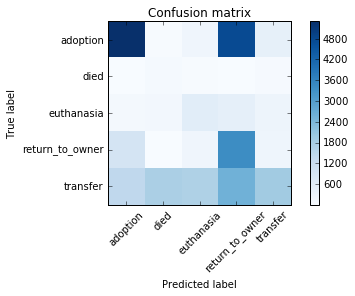

In [43]:
#takes several minutes to train!
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=1000)
fit_model(clf)

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=500)
fit_model(clf)

**Multinomial Naive Bayes**

(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22274, 250) (4455, 250)
(22275, 250) (4454, 250)
Log Loss: 1.65466256912
             precision    recall  f1-score   support

   adoption       0.66      0.73      0.70     10769
       died       0.03      0.01      0.01       197
 euthanasia       0.27      0.23      0.25      1555
return_to_owner       0.42      0.51      0.46      4786
   transfer       0.75      0.60      0.66      9422

avg / total       0.62      0.61      0.61     26729

Confusion matrix, without normalization
[[7892    7  219 1968  683]
 [  13    1   14   14  155]
 [ 159    3  361  369  663]
 [1563    8  335 2460  420]
 [2267   21  384 1106 5644]]


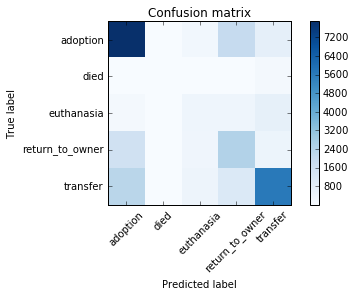

In [45]:
clf = MultinomialNB()
fit_model(clf)

#has decent accuracy but bad log loss

**K Neighbors**

In [50]:
#GridSearchC is not working here, need to debug

#neighbors = {'n_neighbors': range(1,30)}    
#knn = KNeighborsClassifier() #1.44 for all values!
#clf = GridSearchCV(knn, neighbors, n_jobs = 2, scoring='log_loss')
#fit_model(clf)

### Submission

In [ ]:
#train on the entire training set with the chosen model
clf_sub = RandomForestClassifier(n_estimators=1000, n_jobs=3)
y_pred_sub = clf.fit(train_data, train_labels).predict_proba(test_data)


# Prepare the submission file
sub = pd.DataFrame(y_pred_sub, columns=['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
sub.insert(0, 'ID', test_ids.astype(int))

sub.head()

sub.to_csv("C:\\Subha\\WS207-ML\\Kaggle\\git\\submission.csv", index=False)

######  Finally, a shot at Gaussian mixture models

Total Explained variance for the first 50 components:
[ 0.69  0.91  0.94  0.97  0.98  0.98  0.98  0.99  0.99  0.99  0.99  0.99
  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  ]


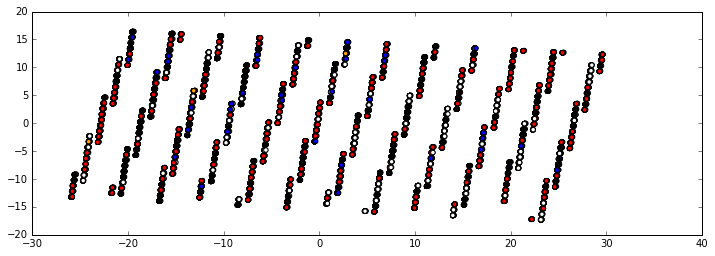

In [54]:

#visualize the trainining data in 2d
pca = PCA()
pca.fit(train_data)
print "Total Explained variance for the first 50 components:"
res = np.cumsum(pca.explained_variance_ratio_)
print res[:50]

pca2d = PCA(n_components=2)
train_2d = pca2d.fit_transform(train_data)

cm_bright = ListedColormap(['red', 'orange', 'blue', 'white', 'black'])
plt.figure(figsize=(12, 4))
plt.scatter(train_2d[:,0], train_2d[:,1], c=train_labels.cat.codes, cmap=cm_bright)

In [58]:

#train- test set split

#add the OutcomeType column back since we will need it for grouping
train_data['OutcomeType'] = train_labels


trainset, testset, trainset_labels, testset_labels = \
    cross_validation.train_test_split(train_data, train_labels, test_size=0.2)
    
print trainset.shape
print testset.shape
print trainset_labels.shape
print testset_labels.shape


(21383, 251)
(5346, 251)
(21383,)
(5346,)


In [59]:
#group by outcome type
outcome_groups = trainset.groupby('OutcomeType')
for name, group in outcome_groups:
    print name, "\t\t", len(group)

adoption_grp = outcome_groups.get_group('adoption')
died_grp = outcome_groups.get_group('died')
euth_grp = outcome_groups.get_group('euthanasia')
return_grp = outcome_groups.get_group('return_to_owner')
transfer_grp = outcome_groups.get_group('transfer')

#drop the outcometype column again; else the models will choke on string data
trainset = trainset.drop('OutcomeType', axis=1)
testset = testset.drop('OutcomeType', axis=1)

adoption_grp = adoption_grp.drop('OutcomeType', axis=1)
died_grp = died_grp.drop('OutcomeType', axis=1)
euth_grp = euth_grp.drop('OutcomeType', axis=1)
return_grp = return_grp.drop('OutcomeType', axis=1)
transfer_grp = transfer_grp.drop('OutcomeType', axis=1)


adoption 		8672
died 		162
euthanasia 		1239
return_to_owner 		3832
transfer 		7478


In [60]:
#get the principal components

pca = PCA(n_components=5)
pca.fit(trainset)

adoption_grp_pca = pca.transform(adoption_grp)
died_grp_pca = pca.transform(died_grp)
euth_grp_pca = pca.transform(euth_grp)
return_grp_pca = pca.transform(return_grp)
transfer_grp_pca = pca.transform(transfer_grp)

testset_pca = pca.transform(testset)

In [62]:
#now fit a GMM
gmm_adoption = GMM(n_components=4, covariance_type='full')
gmm_adoption.fit(adoption_grp_pca)

gmm_died = GMM(n_components=4, covariance_type='full')
gmm_died.fit(died_grp_pca)

gmm_euth = GMM(n_components=4, covariance_type='full')
gmm_euth.fit(euth_grp_pca)

gmm_return = GMM(n_components=4, covariance_type='full')
gmm_return.fit(return_grp_pca)

gmm_transfer = GMM(n_components=4, covariance_type='full')
gmm_transfer.fit(transfer_grp_pca)

testset_proba = np.zeros((len(testset_labels),len(set(testset_labels))))    

#calculate the probabily of the predicted label on test data
testset_proba[:,0] = gmm_adoption.score(testset_pca)
testset_proba[:,1] = gmm_died.score(testset_pca)
testset_proba[:,2] = gmm_euth.score(testset_pca)
testset_proba[:,3] = gmm_return.score(testset_pca)
testset_proba[:,4] = gmm_transfer.score(testset_pca)



In [63]:
testset_proba = np.exp(testset_proba)

labels = testset_labels.categories
print "Log Loss:", metrics.log_loss(testset_labels, testset_proba)  
testset_pred = [labels[row.argmax()] for row in testset_proba]
print metrics.classification_report(testset_labels, testset_pred)

Log Loss: 1.45328550085
             precision    recall  f1-score   support

   adoption       0.62      0.46      0.53      2097
       died       0.03      0.54      0.05        35
 euthanasia       0.10      0.25      0.14       316
return_to_owner       0.32      0.47      0.38       954
   transfer       0.56      0.27      0.36      1944

avg / total       0.51      0.38      0.42      5346

